In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore", message=".*weights_only=False.*") # ignore warning from torch for loading models
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1" 
# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print(project_root)

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle as pkl
from omegaconf import OmegaConf
from einops import rearrange
from tqdm import tqdm
import importlib

/home/mizia/project-2-gradient_tri_scent


In [34]:
# project imports
from src.dataset.datasets.mm_base import build_mm_datasets, MultimodalDataset
import src.dataset.datasets.instance_mask_dataset as imd
importlib.reload(imd)
from src.dataset.datasets.instance_mask_dataset import InstanceMaskDataset # precomputed embeddings ds
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors

from src.models.cellvit_decoder import CellViTDecoder
from src.utils.metrics import CombinedLoss, calculate_dice_score, calculate_f1_score, calculate_panoptic_quality, calculate_iou_score
from src.models.utils.train_loop import train_loop

In [3]:
base_cfg = OmegaConf.load("../src/dataset/configs/base_config.yaml")
base_cfg.marker_embedding_dir = "../src/dataset/esm2_t30_150M_UR50D"
marker_embeddings = load_marker_embeddings(base_cfg.marker_embedding_dir)
orion_subset_cfg = OmegaConf.load("../src/dataset/configs/orion_subset.yaml")
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

In [4]:
ds = build_mm_datasets(ds_cfg)

2025-12-13 19:04:22.172 | DEBUG    | src.dataset.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-12-13 19:04:22.187 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-13 19:04:22.227 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/home/mizia/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future

In [6]:
tissue_ids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()
train_len = int(0.8 * len(tissue_ids))
train_tids = tissue_ids[:train_len]
test_tids = tissue_ids[train_len:]

channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tissue_ids[0]))
tissue = np.array(ds[0].unimodal_datasets["cycif"].get_tissue(tissue_ids[0]))

print(f"Tissue shape: {tissue.shape}")

Tissue shape: (16, 3000, 3000)


In [10]:
instance_mask = ds[0].get_cell_mask(tissue_ids[0], task="segmentation", resize=True)
cell_type_mask = ds[0].get_cell_mask(tissue_ids[0], task="broad_cell_type", resize=True)

Mask shape: (3000, 3000)
Number of instances: 43541
Instance IDs range: 0 to 807708
Background pixels: 6,903,461


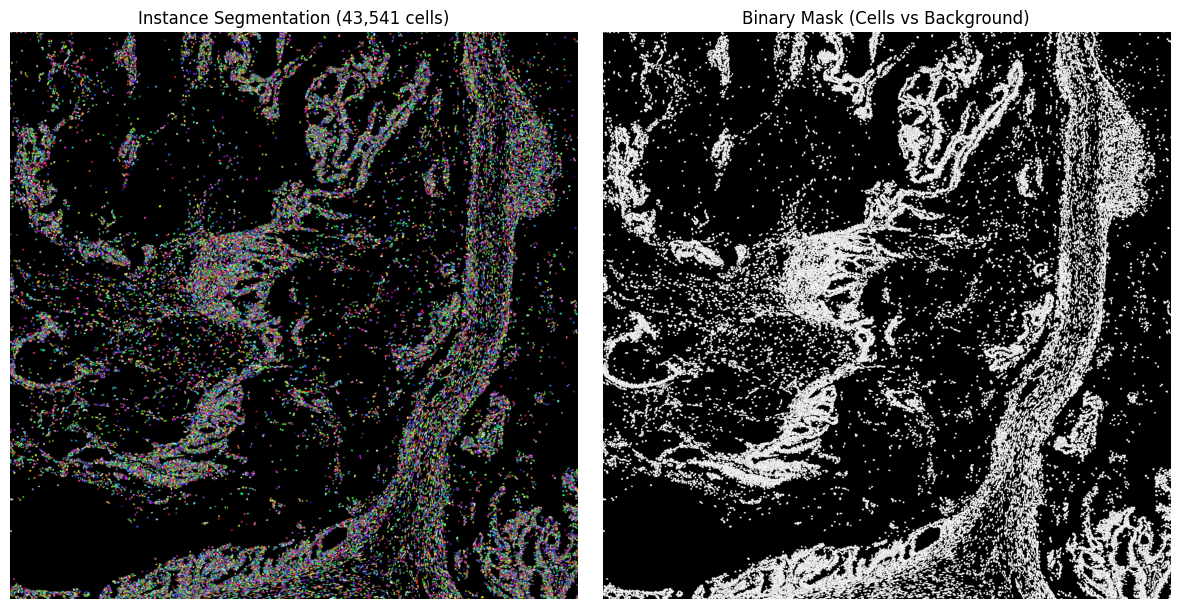

In [15]:
print(f"Mask shape: {instance_mask.shape}")
print(f"Number of instances: {len(np.unique(instance_mask)) - 1}")
print(f"Instance IDs range: {instance_mask.min()} to {instance_mask.max()}")
print(f"Background pixels: {np.sum(instance_mask == 0):,}")

# Get unique instance IDs
unique_ids = np.unique(instance_mask)
num_instances = len(unique_ids) - 1

# Create dense mapping: sparse_id -> dense_index (FAST!)
dense_mask = np.searchsorted(unique_ids, instance_mask)

# Generate random colors
np.random.seed(42)
colors = np.random.rand(len(unique_ids), 3)
colors[0] = [0, 0, 0]  # Background = black

# Vectorized color mapping (INSTANT!)
colored_mask = colors[dense_mask]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(colored_mask)
axes[0].set_title(f"Instance Segmentation ({num_instances:,} cells)")
axes[0].axis('off')

binary_mask = cell_type_mask > 0
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title("Binary Mask (Cells vs Background)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
from scipy.ndimage import find_objects
import numpy as np

def gen_instance_hv_map(inst_map: np.ndarray) -> np.ndarray:
    """
    Generate horizontal and vertical distance maps. Vectorized version of CellVit function found at 
    https://github.com/TIO-IKIM/CellViT/blob/main/cell_segmentation/utils/tools.py#L24
    
    Args:
        inst_map: Instance map (H, W) with unique integer per instance
        
    Returns:
        hv_map: (2, H, W) - horizontal and vertical gradients [-1, 1]
    """
    orig_inst_map = inst_map.astype(np.int32)
    
    x_map = np.zeros(orig_inst_map.shape, dtype=np.float32)
    y_map = np.zeros(orig_inst_map.shape, dtype=np.float32)
    
    inst_list = np.unique(orig_inst_map)
    inst_list = inst_list[inst_list != 0]
    
    slices = find_objects(orig_inst_map)
    
    for inst_id in tqdm(inst_list, desc="Generating HV maps"):
        if inst_id == 0 or inst_id - 1 >= len(slices):
            continue
            
        slice_obj = slices[inst_id - 1]
        if slice_obj is None:
            continue
            
        y_slice, x_slice = slice_obj
        y_start, y_end = y_slice.start, y_slice.stop
        x_start, x_end = x_slice.start, x_slice.stop
        
        y_start = max(0, y_start - 2)
        x_start = max(0, x_start - 2)
        y_end = min(orig_inst_map.shape[0], y_end + 2)
        x_end = min(orig_inst_map.shape[1], x_end + 2)
        
        inst_map_crop = (orig_inst_map[y_start:y_end, x_start:x_end] == inst_id).astype(np.uint8)
        
        if inst_map_crop.shape[0] < 2 or inst_map_crop.shape[1] < 2:
            continue
        
        y_coords, x_coords = np.nonzero(inst_map_crop)
        if len(y_coords) == 0:
            continue
            
        inst_com_y = int(np.mean(y_coords) + 0.5)
        inst_com_x = int(np.mean(x_coords) + 0.5)
        
        h, w = inst_map_crop.shape
        inst_y_range = np.arange(1, h + 1) - inst_com_y
        inst_x_range = np.arange(1, w + 1) - inst_com_x
        
        inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)
        
        inst_x = inst_x.astype(np.float32)
        inst_y = inst_y.astype(np.float32)
        inst_x[inst_map_crop == 0] = 0
        inst_y[inst_map_crop == 0] = 0
        
        x_neg = inst_x < 0
        x_pos = inst_x > 0
        y_neg = inst_y < 0
        y_pos = inst_y > 0
        
        if x_neg.any():
            inst_x[x_neg] /= -inst_x[x_neg].min()
        if x_pos.any():
            inst_x[x_pos] /= inst_x[x_pos].max()
        if y_neg.any():
            inst_y[y_neg] /= -inst_y[y_neg].min()
        if y_pos.any():
            inst_y[y_pos] /= inst_y[y_pos].max()
        
        mask_region = inst_map_crop > 0
        x_map[y_start:y_end, x_start:x_end][mask_region] = inst_x[mask_region]
        y_map[y_start:y_end, x_start:x_end][mask_region] = inst_y[mask_region]
    
    hv_map = np.stack([x_map, y_map])
    return hv_map

In [25]:
hv_map = gen_instance_hv_map(instance_mask)

Generating HV maps...
Processing 43541 instances...


Generating HV maps: 100%|██████████| 43541/43541 [00:04<00:00, 9298.20it/s]


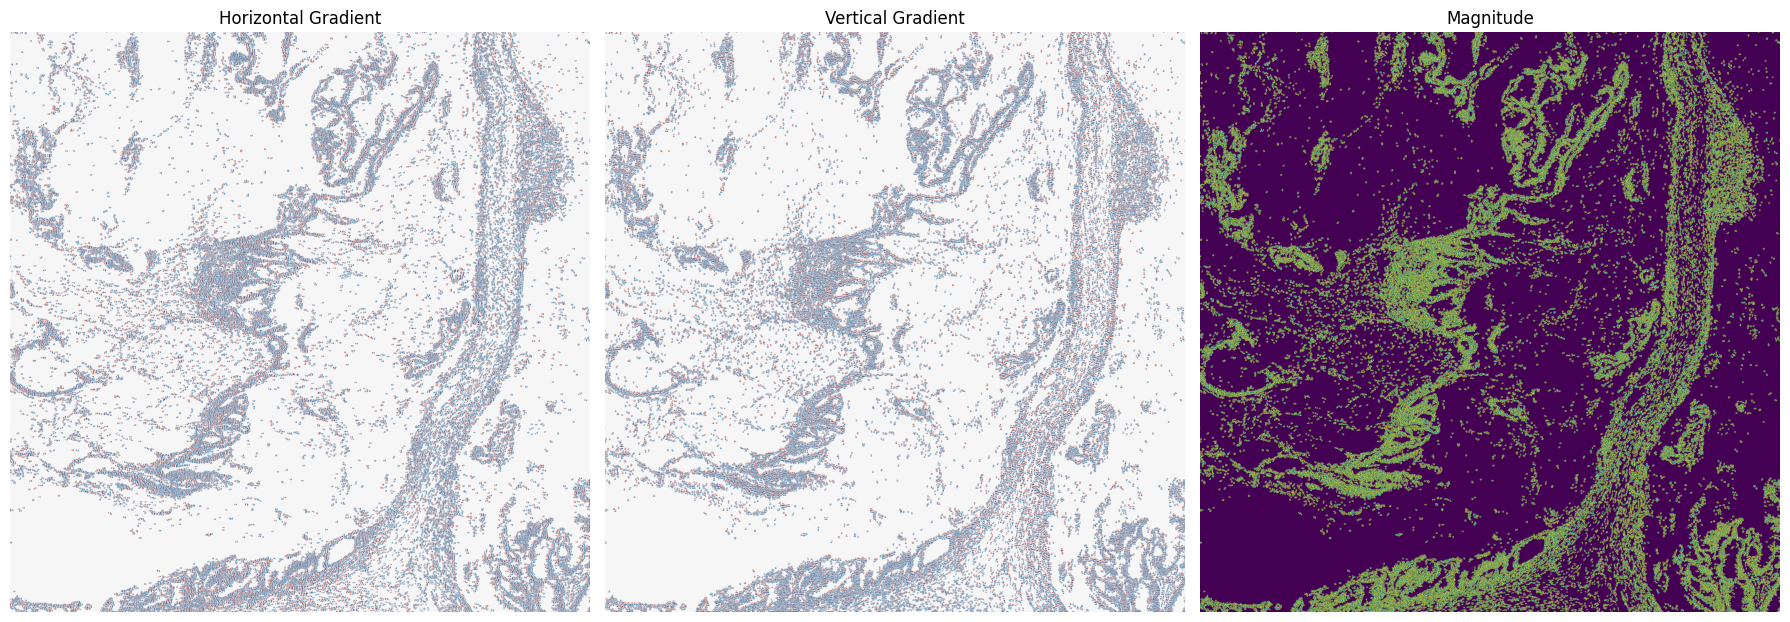

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 12))

axes[0].imshow(hv_map[0], cmap='RdBu', vmin=-1, vmax=1)
axes[0].set_title("Horizontal Gradient")
axes[0].axis('off')

axes[1].imshow(hv_map[1], cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title("Vertical Gradient")
axes[1].axis('off')

axes[2].imshow(np.sqrt(hv_map[0]**2 + hv_map[1]**2), cmap='viridis', vmin=0, vmax=1)
axes[2].set_title("Magnitude")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [30]:
from src.models.wrappers.virtues_wrapper import VirtuesWrapper 
from src.
# wrapper = VirtuesWrapper(encoder=torch.nn.Identity(), device="cuda", autocast_dtype=torch.float16) # mock encoder

In [31]:
from_scratch=False
path = os.path.join("/data", "embeddings", "virtues_sp_he")
if from_scratch:
    # SP Only, include_he_data=False by default
    wrapper.process_dataset(ds[0], return_intermediates=True, intermediate_layers=[4,8,12])
    wrapper.save_embeddings(path)
else:
    wrapper.load_embeddings(path)

100%|██████████| 35/35 [00:48<00:00,  1.37s/it]


In [ ]:
all_items = [(tid, emb["pss"], emb["intermediate_pss"]) for tid, emb in wrapper.embeddings.items()]
n = len(all_items)
train_items = all_items[: int(0.8 * n)]
test_items  = all_items[int(0.8 * n):]

# 25x25 batches from 375x375 => each is 15x15 patches => 120x120 px (120=15xpatch_size)
train_ds = InstanceMaskDataset(train_items, ds=ds[0], batches_from_item=25)
test_ds  = InstanceMaskDataset(test_items, ds=ds[0], batches_from_item=25)

def collate_batch(batch):
    _, he_img, mask, pss, intermediate_pss = zip(*batch)
    inter = [torch.stack([it[i] for it in intermediate_pss]) for i in range(len(intermediate_pss[0]))]
    return torch.stack(pss), torch.stack(mask), torch.stack(he_img), inter  # pss: (B, h, w, D), mask: (B, H, W)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, collate_fn=collate_batch, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0, collate_fn=collate_batch, pin_memory=True)